# Create A Multi-Layer Perceptron (MLP) For Predicting The Next Character In A Sequence

- [Andrej Karpathy YouTube Tutorial](https://www.youtube.com/watch?v=TCH_1BHY58I&t=541s&ab_channel=AndrejKarpathy)
- [A Neural Probabilistic Language Model (Paper)](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

In [1]:
%load_ext watermark
%watermark -v -p numpy,pandas,polars,torch,lightning --conda

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.22.2

numpy    : 1.26.4
pandas   : 2.2.1
polars   : 0.20.18
torch    : 2.2.2
lightning: 2.2.1

conda environment: torch_p11



In [2]:
# Built-in library
from pathlib import Path
import re
import json
from typing import Any, Optional, Union
import logging
import warnings

# Standard imports
import numpy as np
import numpy.typing as npt
from pprint import pprint
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "info": "#76FF7B",
        "warning": "#FBDDFE",
        "error": "#FF0000",
    }
)
console = Console(theme=custom_theme)

# Visualization
import matplotlib.pyplot as plt


# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

warnings.filterwarnings("ignore")


# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F

In [4]:
def load_data(file_path: str) -> list[str]:
    """Load text data from a file and return as a list of strings."""

    with open(file_path, "r") as f:
        # Read all the lines as a list
        data: list[str] = f.read().splitlines()

    return data

In [5]:
# Load Data
fp: str = "../../../data/names.txt"
names: list[str] = load_data(file_path=fp)

names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

### Build Vocabulary Of Characters And Mappings

In [6]:
set("".join(names))

{'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z'}

In [7]:
special_token: str = "."
characters: list[str] = sorted(set("".join(names)))
# Add the special token to the beginning of the list.
characters.insert(0, special_token)
n_chars: int = len(characters)

# Convert text to numbers.
text_to_num: dict[str, int] = {text: idx for idx, text in enumerate(characters)}
# Convert numbers to text
num_to_text: dict[int, str] = {idx: text for text, idx in text_to_num.items()}


console.print(text_to_num, num_to_text)

{
    '.': 0,
    'a': 1,
    'b': 2,
    'c': 3,
    'd': 4,
    'e': 5,
    'f': 6,
    'g': 7,
    'h': 8,
    'i': 9,
    'j': 10,
    'k': 11,
    'l': 12,
    'm': 13,
    'n': 14,
    'o': 15,
    'p': 16,
    'q': 17,
    'r': 18,
    's': 19,
    't': 20,
    'u': 21,
    'v': 22,
    'w': 23,
    'x': 24,
    'y': 25,
    'z': 26
}
{
    0: '.',
    1: 'a',
    2: 'b',
    3: 'c',
    4: 'd',
    5: 'e',
    6: 'f',
    7: 'g',
    8: 'h',
    9: 'i',
    10: 'j',
    11: 'k',
    12: 'l',
    13: 'm',
    14: 'n',
    15: 'o',
    16: 'p',
    17: 'q',
    18: 'r',
    19: 's',
    20: 't',
    21: 'u',
    22: 'v',
    23: 'w',
    24: 'x',
    25: 'y',
    26: 'z'
}

In [8]:
def build_dataset(
    names: list[str],
    special_token: str = ".",
    block_size: int = 3,
    print_info: bool = False,
) -> tuple[Tensor, Tensor]:
    """
    Builds a dataset of name sequences and their corresponding character indices.

    Args:
        names (list[str]): A list of names to build the dataset from.
        special_token (str, optional): A special token to append to the end of each name. Defaults to ".".
        block_size (int, optional): The size of the context window for each input sequence. Defaults to 3.
        print_info (bool, optional): Whether to print information about the dataset generation. Defaults to False.

    Returns:
        tuple[Tensor, Tensor]: A tuple containing the input sequences (X) and their corresponding target indices (Y).
    """
    X, Y = [], []

    for w in names:
        if print_info:
            print(w)
        context: list[str] = [0] * block_size

        for ch in w + special_token:
            ix: int = text_to_num.get(ch)
            X.append(context)
            Y.append(ix)

            if print_info:
                print(
                    f"{''.join([num_to_text.get(i) for i in context])} ---> {num_to_text.get(ix)}"
                )

            # Crop and append, like a rolling window
            context = context[1:] + [ix]

    X: Tensor = torch.tensor(X)
    Y: Tensor = torch.tensor(Y)
    print(f"\n{X.shape=}, {Y.shape=}")
    return (X, Y)

In [9]:
X, y = build_dataset(names=names[:5], block_size=3, print_info=True)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .

X.shape=torch.Size([32, 3]), Y.shape=torch.Size([32])


In [10]:
X.shape, y.shape

(torch.Size([32, 3]), torch.Size([32]))

<img src="../images/mlp 1.png" width="600">

In [11]:
# Step 1: Build an embedding lookup table
emb_dim: int = 2  # embedding dimension
C: Tensor = torch.randn((n_chars, emb_dim))

print(f"{C.shape = }")
C

C.shape = torch.Size([27, 2])


tensor([[ 1.3246, -1.3964],
        [-0.0597, -1.5406],
        [ 0.1417, -0.5105],
        [ 1.1305, -1.6952],
        [ 0.0074,  1.4435],
        [ 1.8612, -0.7980],
        [-1.2746,  0.2289],
        [-0.1252,  1.1409],
        [ 1.3077,  1.7808],
        [ 0.9239,  0.7844],
        [-1.0299,  1.6010],
        [ 0.7274,  0.4220],
        [-1.2546,  0.5707],
        [-0.8951, -0.3657],
        [-0.6252, -0.6598],
        [-0.0373,  0.7838],
        [-1.3026,  1.7094],
        [ 0.1716, -2.0623],
        [ 0.2576,  0.1953],
        [-0.8220,  0.7074],
        [-1.5219,  0.0368],
        [-0.0923,  3.1386],
        [-0.0676, -1.2722],
        [-0.8483,  1.3211],
        [-0.9451, -1.9714],
        [ 0.1102, -0.5717],
        [ 0.2732, -0.8895]])

In [12]:
# Embed the inputs
# Method 1
C[5]

tensor([ 1.8612, -0.7980])

In [13]:
# Method 2
F.one_hot(torch.tensor(5), num_classes=n_chars).float() @ C

tensor([ 1.8612, -0.7980])

In [14]:
# Embed the entire input
emb: Tensor = C[X]
print(f"{emb.shape=}")
emb

emb.shape=torch.Size([32, 3, 2])


tensor([[[ 1.3246, -1.3964],
         [ 1.3246, -1.3964],
         [ 1.3246, -1.3964]],

        [[ 1.3246, -1.3964],
         [ 1.3246, -1.3964],
         [ 1.8612, -0.7980]],

        [[ 1.3246, -1.3964],
         [ 1.8612, -0.7980],
         [-0.8951, -0.3657]],

        [[ 1.8612, -0.7980],
         [-0.8951, -0.3657],
         [-0.8951, -0.3657]],

        [[-0.8951, -0.3657],
         [-0.8951, -0.3657],
         [-0.0597, -1.5406]],

        [[ 1.3246, -1.3964],
         [ 1.3246, -1.3964],
         [ 1.3246, -1.3964]],

        [[ 1.3246, -1.3964],
         [ 1.3246, -1.3964],
         [-0.0373,  0.7838]],

        [[ 1.3246, -1.3964],
         [-0.0373,  0.7838],
         [-1.2546,  0.5707]],

        [[-0.0373,  0.7838],
         [-1.2546,  0.5707],
         [ 0.9239,  0.7844]],

        [[-1.2546,  0.5707],
         [ 0.9239,  0.7844],
         [-0.0676, -1.2722]],

        [[ 0.9239,  0.7844],
         [-0.0676, -1.2722],
         [ 0.9239,  0.7844]],

        [[-0.0676, -1

In [15]:
# OR
# Method 2
emb1: Tensor = F.one_hot(X, num_classes=n_chars).float() @ C
print(f"{emb1.shape=}")
emb1

emb1.shape=torch.Size([32, 3, 2])


tensor([[[ 1.3246, -1.3964],
         [ 1.3246, -1.3964],
         [ 1.3246, -1.3964]],

        [[ 1.3246, -1.3964],
         [ 1.3246, -1.3964],
         [ 1.8612, -0.7980]],

        [[ 1.3246, -1.3964],
         [ 1.8612, -0.7980],
         [-0.8951, -0.3657]],

        [[ 1.8612, -0.7980],
         [-0.8951, -0.3657],
         [-0.8951, -0.3657]],

        [[-0.8951, -0.3657],
         [-0.8951, -0.3657],
         [-0.0597, -1.5406]],

        [[ 1.3246, -1.3964],
         [ 1.3246, -1.3964],
         [ 1.3246, -1.3964]],

        [[ 1.3246, -1.3964],
         [ 1.3246, -1.3964],
         [-0.0373,  0.7838]],

        [[ 1.3246, -1.3964],
         [-0.0373,  0.7838],
         [-1.2546,  0.5707]],

        [[-0.0373,  0.7838],
         [-1.2546,  0.5707],
         [ 0.9239,  0.7844]],

        [[-1.2546,  0.5707],
         [ 0.9239,  0.7844],
         [-0.0676, -1.2722]],

        [[ 0.9239,  0.7844],
         [-0.0676, -1.2722],
         [ 0.9239,  0.7844]],

        [[-0.0676, -1

In [16]:
emb.equal(emb1)

True

In [17]:
emb.shape

torch.Size([32, 3, 2])

In [18]:
emb[1], emb[1].shape

(tensor([[ 1.3246, -1.3964],
         [ 1.3246, -1.3964],
         [ 1.8612, -0.7980]]),
 torch.Size([3, 2]))

In [19]:
emb[13, 2]

tensor([-0.0597, -1.5406])

In [20]:
# Step 2: Build The Hidden Layer
block_size: int = 3
W1: Tensor = torch.randn((emb_dim * block_size, 100))
b1: Tensor = torch.randn(100)

# Forward pass
h: Tensor = emb.view(-1, 6) @ W1 + b1
# Apply a non-linearity
h = torch.tanh(h)
h.shape

torch.Size([32, 100])

In [21]:
# Step 3: Output Layer
W2: Tensor = torch.randn(h.shape[-1], n_chars, requires_grad=True)  # (100, 27)
b2: Tensor = torch.zeros(n_chars, requires_grad=True)  # (27,)

logits: Tensor = torch.matmul(h, W2) + b2  # h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [22]:
# Convert logits to `fake` counts
counts: Tensor = logits.exp()
# Normalize: Apply Softmax
probs: Tensor = counts / counts.sum(dim=-1, keepdim=True)

probs[0].sum(), probs[15].sum()

(tensor(1.0000, grad_fn=<SumBackward0>), tensor(1., grad_fn=<SumBackward0>))

In [23]:
# Negative log likelihood loss
loss: Tensor = -1 * probs[torch.arange(logits.shape[0]), y].log().mean()
loss

tensor(18.5628, grad_fn=<MulBackward0>)

#### Combine The Previous Cells

- `F.categorical_crossentropy()` is used instead of manually calculating the loss because it's more numerically stable and efficient.

In [24]:
X, y = build_dataset(names=names, block_size=3, print_info=False)


X.shape=torch.Size([228152, 3]), Y.shape=torch.Size([228152])


In [25]:
torch.randint(0, X.shape[0], size=(16,))

tensor([140685, 150165, 145551,  50881, 223009,  92295,  91205, 210296,  50472,
        161618,  38975, 145451, 141483, 164257,  55452, 160751])

In [26]:
g = torch.Generator().manual_seed(5)

# Parameters
emb_dim: int = 2  # embedding dimension
block_size: int = 3  # size of the context window for each input sequence
M: int = emb_dim * block_size  # number of inputs
n_nodes: int = 100  # number of hidden nodes
learning_rate: float = 0.1  # learning rate
batch_size: int = 32  # batch size
epochs: int = 1_000  # number of epochs
C: Tensor = torch.randn((n_chars, emb_dim), generator=g)
W1: Tensor = torch.randn((M, n_nodes), generator=g)
b1: Tensor = torch.randn(n_nodes, generator=g)
W2: Tensor = torch.randn(n_nodes, n_chars, generator=g)  # (100, 27)
b2: Tensor = torch.randn(n_chars, generator=g)  # (27,)
print(f"{C.shape = }")
parameters: list[Tensor] = [C, W1, b1, W2, b2]
n_parameters: int = sum([p.nelement() for p in parameters])
print(f"{n_parameters = :,}")

C.shape = torch.Size([27, 2])
n_parameters = 3,481


In [27]:
# Require gradients to be true
for p in parameters:
    p.requires_grad = True

In [28]:
# Calculate the optimal learning rate
lr_exp: Tensor = torch.linspace(-3, 0, 1000)
lr: Tensor = 10**lr_exp  # 10^-3, 10^-2, ..., 10^0
lr

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [29]:
lr_all: list[float] = []
losses_all: list[float] = []

for epoch in range(epochs):

    # Add mini-batches
    idx: Tensor = torch.randint(0, X.shape[0], size=(batch_size,))

    # Step 1: Build an embedding lookup table
    # Embed the input
    emb: Tensor = F.one_hot(X[idx], num_classes=n_chars).float() @ C

    # Forward pass
    # Step 2: Build The Hidden Layer
    # Reshape the input to match the shape of the weight matrix
    h: Tensor = emb.view(-1, M) @ W1 + b1
    # Apply a non-linearity
    h = torch.tanh(h)

    # Step 3: Output Layer
    logits: Tensor = torch.matmul(h, W2) + b2  # h @ W2 + b2

    # Calculate the loss: Negative log likelihood loss
    loss: Tensor = F.cross_entropy(logits, y[idx])

    # Backward pass
    # Reset gradients
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        p.data -= lr[epoch] * p.grad

    # Log learning rate and loss
    lr_all.append(lr_exp[epoch])
    losses_all.append(loss.item())

    print(f"Epoch: {epoch+1}/{epochs} | Loss: {loss.item():.4f}")

Epoch: 1/1000 | Loss: 13.7095
Epoch: 2/1000 | Loss: 16.3323
Epoch: 3/1000 | Loss: 14.8641
Epoch: 4/1000 | Loss: 14.0836
Epoch: 5/1000 | Loss: 15.5005
Epoch: 6/1000 | Loss: 15.1659
Epoch: 7/1000 | Loss: 15.8856
Epoch: 8/1000 | Loss: 17.2998
Epoch: 9/1000 | Loss: 17.1179
Epoch: 10/1000 | Loss: 15.9856
Epoch: 11/1000 | Loss: 18.7349
Epoch: 12/1000 | Loss: 16.3602
Epoch: 13/1000 | Loss: 17.4807
Epoch: 14/1000 | Loss: 15.8326
Epoch: 15/1000 | Loss: 14.7563
Epoch: 16/1000 | Loss: 15.5763
Epoch: 17/1000 | Loss: 14.7127
Epoch: 18/1000 | Loss: 15.7949
Epoch: 19/1000 | Loss: 16.2737
Epoch: 20/1000 | Loss: 15.9543
Epoch: 21/1000 | Loss: 15.9063
Epoch: 22/1000 | Loss: 14.8632
Epoch: 23/1000 | Loss: 15.5156
Epoch: 24/1000 | Loss: 16.1883
Epoch: 25/1000 | Loss: 15.9510
Epoch: 26/1000 | Loss: 17.4087
Epoch: 27/1000 | Loss: 14.8092
Epoch: 28/1000 | Loss: 17.1351
Epoch: 29/1000 | Loss: 15.5750
Epoch: 30/1000 | Loss: 13.2288
Epoch: 31/1000 | Loss: 15.9701
Epoch: 32/1000 | Loss: 13.8737
Epoch: 33/1000 | 

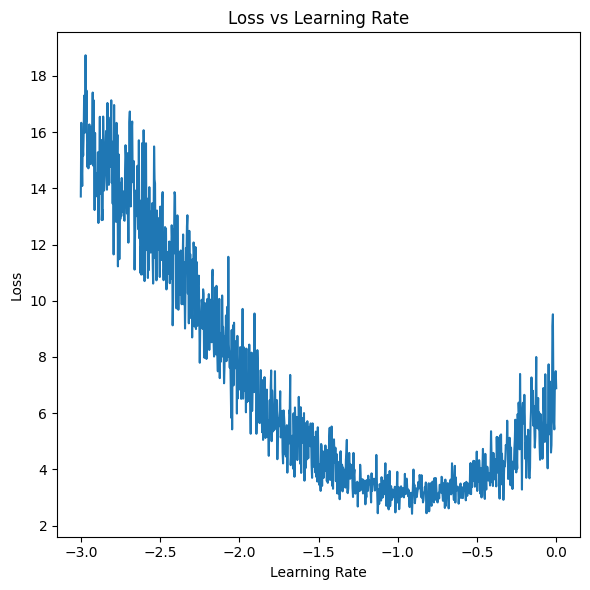

In [30]:
# plt.figure(figsize=(6, 6))
# plt.plot(lr_all, losses_all)
# plt.xlabel("Learning Rate")
# plt.ylabel("Loss")
# plt.title("Loss vs Learning Rate")
# plt.show()


fig, ax = plt.subplots(figsize=(6, 6))  # Create figure and axes
ax.plot(lr_all, losses_all)  # Plot the data
ax.set(xlabel="Learning Rate", ylabel="Loss", title="Loss vs Learning Rate")
plt.tight_layout()
plt.show()

#### Comment

- From the figure above, it seems the learning rate is optimal when:
  - lr_exp = -1.0 ; i.e. lr = 10^-1.0 = 0.1

In [31]:
X, y = build_dataset(names=names, block_size=3, print_info=False)


X.shape=torch.Size([228152, 3]), Y.shape=torch.Size([228152])


#### Re-train The Model

In [32]:
g = torch.Generator().manual_seed(5)

# Parameters
emb_dim: int = 2  # embedding dimension
block_size: int = 3  # size of the context window for each input sequence
M: int = emb_dim * block_size  # number of inputs
n_nodes: int = 100  # number of hidden nodes
learning_rate: float = 0.1  # learning rate
batch_size: int = 32  # batch size
epochs: int = 30_000  # number of epochs
C: Tensor = torch.randn((n_chars, emb_dim), generator=g)
W1: Tensor = torch.randn((M, n_nodes), generator=g)
b1: Tensor = torch.randn(n_nodes, generator=g)
W2: Tensor = torch.randn(n_nodes, n_chars, generator=g)  # (100, 27)
b2: Tensor = torch.randn(n_chars, generator=g)  # (27,)
print(f"{C.shape = }")
parameters: list[Tensor] = [C, W1, b1, W2, b2]
n_parameters: int = sum([p.nelement() for p in parameters])
print(f"{n_parameters = :,}")

C.shape = torch.Size([27, 2])
n_parameters = 3,481


In [33]:
# Require gradients to be true
for p in parameters:
    p.requires_grad = True

In [34]:
# Use The optimal learning rate to train the model
losses_all: list[float] = []

for epoch in range(epochs):

    # Add mini-batches
    idx: Tensor = torch.randint(0, X.shape[0], size=(batch_size,))

    # Step 1: Build an embedding lookup table
    # Embed the input
    emb: Tensor = F.one_hot(X[idx], num_classes=n_chars).float() @ C

    # Forward pass
    # Step 2: Build The Hidden Layer
    # Reshape the input to match the shape of the weight matrix
    h: Tensor = emb.view(-1, M) @ W1 + b1
    # Apply a non-linearity
    h = torch.tanh(h)

    # Step 3: Output Layer
    logits: Tensor = torch.matmul(h, W2) + b2  # h @ W2 + b2

    # Calculate the loss: Negative log likelihood loss
    loss: Tensor = F.cross_entropy(logits, y[idx])

    # Backward pass
    # Reset gradients
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    for p in parameters:
        p.data -= learning_rate * p.grad

    # Record the loss
    losses_all.append(loss.item())

    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch+1}/{epochs} | Loss: {loss.item():.4f}")

Epoch: 100/30000 | Loss: 4.4873
Epoch: 200/30000 | Loss: 3.5627
Epoch: 300/30000 | Loss: 2.7418
Epoch: 400/30000 | Loss: 2.9545
Epoch: 500/30000 | Loss: 2.6811
Epoch: 600/30000 | Loss: 2.7441
Epoch: 700/30000 | Loss: 2.8659
Epoch: 800/30000 | Loss: 2.9412
Epoch: 900/30000 | Loss: 2.6347
Epoch: 1000/30000 | Loss: 2.8131
Epoch: 1100/30000 | Loss: 3.0659
Epoch: 1200/30000 | Loss: 2.2036
Epoch: 1300/30000 | Loss: 2.5585
Epoch: 1400/30000 | Loss: 3.1798
Epoch: 1500/30000 | Loss: 2.6684
Epoch: 1600/30000 | Loss: 2.6842
Epoch: 1700/30000 | Loss: 2.3964
Epoch: 1800/30000 | Loss: 2.5780
Epoch: 1900/30000 | Loss: 2.5692
Epoch: 2000/30000 | Loss: 2.9990
Epoch: 2100/30000 | Loss: 2.4503
Epoch: 2200/30000 | Loss: 2.3203
Epoch: 2300/30000 | Loss: 2.5601
Epoch: 2400/30000 | Loss: 2.6166
Epoch: 2500/30000 | Loss: 2.4375
Epoch: 2600/30000 | Loss: 2.5426
Epoch: 2700/30000 | Loss: 2.8171
Epoch: 2800/30000 | Loss: 2.8631
Epoch: 2900/30000 | Loss: 2.3652
Epoch: 3000/30000 | Loss: 2.4592
Epoch: 3100/30000 |

In [35]:
# Average loss
np.mean(losses_all)

2.4853585920373598

In [36]:
# Actual loss
emb: Tensor = F.one_hot(X, num_classes=n_chars).float() @ C
h: Tensor = emb.view(-1, M) @ W1 + b1
h = torch.tanh(h)
logits: Tensor = torch.matmul(h, W2) + b2  # h @ W2 + b2

loss: Tensor = F.cross_entropy(logits, y)
loss

tensor(2.3997, grad_fn=<NllLossBackward0>)

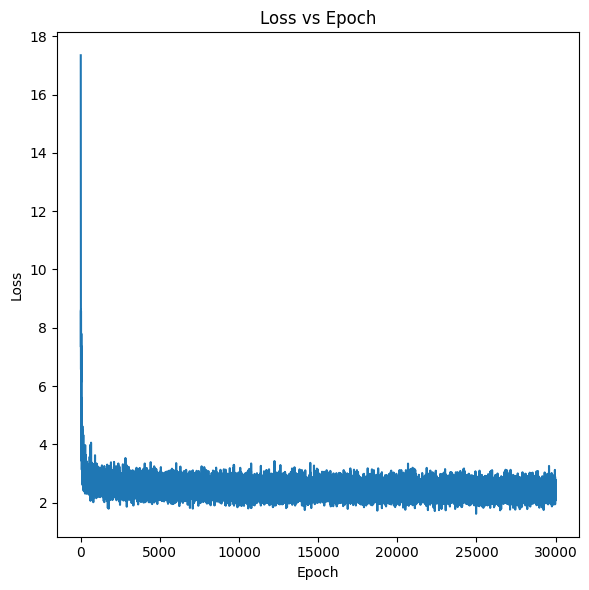

In [37]:
fig, ax = plt.subplots(figsize=(6, 6))  # Create figure and axes
ax.plot(torch.arange(epochs), losses_all)  # Plot the data
ax.set(xlabel="Epoch", ylabel="Loss", title="Loss vs Epoch")  # Add labels
plt.tight_layout()
plt.show()

### Split Into Train, Dev And Test Sets

In [38]:
from torch.utils.data import random_split, TensorDataset, Dataset

from sklearn.model_selection import train_test_split


def split_data_into_train_dev_test(
    data: Tensor | Dataset, test_size: float = 0.05, dev_size: float = 0.1, seed=42
) -> tuple[Tensor, ...]:
    """
    Splits a given PyTorch tensor `data` into training, development, and test sets.

    Params:
    -------
        data (torch.Tensor): The input tensor to be split.
        test_size (float, optional): The fraction of the data to use for the test set. Defaults to 0.2.
        dev_size (float, optional): The fraction of the data to use for the development set. Defaults to 0.1.
        seed (int, optional): The random seed to use for reproducibility. Defaults to 42.

    Returns:
    --------
        tuple[torch.Tensor, torch.Tensor, torch.Tensor]: The training, development, and test sets as PyTorch tensors.
    """
    if isinstance(data, Tensor):
        X_train, X_test = train_test_split(data, test_size=test_size, random_state=seed)
        X_train, X_dev = train_test_split(
            X_train, test_size=dev_size, random_state=seed
        )
        result: tuple[Tensor, ...] = (X_train, X_dev, X_test)
    if isinstance(data, Dataset):
        X_train, X_test, y_train, y_test = train_test_split(
            data.data,
            data.targets,
            test_size=test_size,
            random_state=seed,
            stratify=data.targets,
        )
        X_train, X_dev, y_train, y_dev = train_test_split(
            X_train, y_train, test_size=dev_size, random_state=seed, stratify=y_train
        )
        result: tuple[Tensor, ...] = (X_train, X_dev, X_test, y_train, y_dev, y_test)

    print(f"{X_train.shape=}; {X_dev.shape=}; {X_test.shape=}")

    return result


class MyDataset(Dataset):
    def __init__(self, data: Tensor, targets: Tensor) -> None:
        self.data = data
        self.targets = targets

    def __repr__(self) -> str:
        return (
            f"{self.__class__.__name__}(data.shape={self.data.shape}, "
            f"target.shape={self.targets.shape=})"
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.targets[idx]
        return x, y

In [39]:
X, y = build_dataset(names=names, block_size=3, print_info=False)
data: Dataset = MyDataset(X, y)

data


X.shape=torch.Size([228152, 3]), Y.shape=torch.Size([228152])


MyDataset(data.shape=torch.Size([228152, 3]), target.shape=self.targets.shape=torch.Size([228152]))

In [40]:
X_train, X_dev, X_test, y_train, y_dev, y_test = split_data_into_train_dev_test(
    data=data
)

X_train.shape=torch.Size([195069, 3]); X_dev.shape=torch.Size([21675, 3]); X_test.shape=torch.Size([11408, 3])


In [41]:
g = torch.Generator().manual_seed(5)

# Parameters
emb_dim: int = 2  # embedding dimension
block_size: int = 3  # size of the context window for each input sequence
M: int = emb_dim * block_size  # number of inputs
n_nodes: int = 100  # number of hidden nodes
learning_rate: float = 0.1  # learning rate
batch_size: int = 32  # batch size
epochs: int = 50_000  # number of epochs
C: Tensor = torch.randn((n_chars, emb_dim), generator=g)
W1: Tensor = torch.randn((M, n_nodes), generator=g)
b1: Tensor = torch.randn(n_nodes, generator=g)
W2: Tensor = torch.randn(n_nodes, n_chars, generator=g)  # (100, 27)
b2: Tensor = torch.randn(n_chars, generator=g)  # (27,)
print(f"{C.shape = }")
parameters: list[Tensor] = [C, W1, b1, W2, b2]
n_parameters: int = sum([p.nelement() for p in parameters])
print(f"{n_parameters = :,}")

C.shape = torch.Size([27, 2])
n_parameters = 3,481


In [42]:
# Require gradients to be true
for p in parameters:
    p.requires_grad = True

In [43]:
# Use The optimal learning rate to train the model
losses_all: list[float] = []

for epoch in range(epochs):

    # Add mini-batches
    idx: Tensor = torch.randint(0, X_train.shape[0], size=(batch_size,))

    # Step 1: Build an embedding lookup table
    # Embed the input
    emb: Tensor = F.one_hot(X_train[idx], num_classes=n_chars).float() @ C

    # Forward pass
    # Step 2: Build The Hidden Layer
    # Reshape the input to match the shape of the weight matrix
    h: Tensor = emb.view(-1, M) @ W1 + b1
    # Apply a non-linearity
    h = torch.tanh(h)

    # Step 3: Output Layer
    logits: Tensor = torch.matmul(h, W2) + b2  # h @ W2 + b2

    # Calculate the loss: Negative log likelihood loss
    loss: Tensor = F.cross_entropy(logits, y_train[idx])

    # Backward pass
    # Reset gradients
    for p in parameters:
        p.grad = None
    loss.backward()

    # learning rate decay
    if epoch > 20_000:
        learning_rate = 0.01
    elif epoch > 28_000:
        learning_rate = 0.001

    # Update the parameters
    for p in parameters:
        p.data -= learning_rate * p.grad

    # Record the loss
    losses_all.append(loss.item())

    if (epoch + 1) % 1_000 == 0:
        print(f"Epoch: {epoch+1}/{epochs} | Loss: {loss.item():.4f}")

Epoch: 1000/50000 | Loss: 2.9020
Epoch: 2000/50000 | Loss: 2.3887
Epoch: 3000/50000 | Loss: 2.5458
Epoch: 4000/50000 | Loss: 2.1807
Epoch: 5000/50000 | Loss: 2.3984
Epoch: 6000/50000 | Loss: 2.5700
Epoch: 7000/50000 | Loss: 2.7051
Epoch: 8000/50000 | Loss: 2.8248
Epoch: 9000/50000 | Loss: 2.7232
Epoch: 10000/50000 | Loss: 2.4250
Epoch: 11000/50000 | Loss: 2.5984
Epoch: 12000/50000 | Loss: 2.5429
Epoch: 13000/50000 | Loss: 2.2923
Epoch: 14000/50000 | Loss: 2.6194
Epoch: 15000/50000 | Loss: 2.2960
Epoch: 16000/50000 | Loss: 2.6873
Epoch: 17000/50000 | Loss: 2.7491
Epoch: 18000/50000 | Loss: 2.3598
Epoch: 19000/50000 | Loss: 2.3747
Epoch: 20000/50000 | Loss: 2.1369
Epoch: 21000/50000 | Loss: 2.3839
Epoch: 22000/50000 | Loss: 2.4758
Epoch: 23000/50000 | Loss: 2.4182
Epoch: 24000/50000 | Loss: 2.1986
Epoch: 25000/50000 | Loss: 2.4602
Epoch: 26000/50000 | Loss: 2.0207
Epoch: 27000/50000 | Loss: 2.0843
Epoch: 28000/50000 | Loss: 2.2759
Epoch: 29000/50000 | Loss: 2.2678
Epoch: 30000/50000 | Lo

In [44]:
# Train loss
emb: Tensor = F.one_hot(X_train, num_classes=n_chars).float() @ C
h: Tensor = emb.view(-1, M) @ W1 + b1
h = torch.tanh(h)
logits: Tensor = torch.matmul(h, W2) + b2  # h @ W2 + b2

loss: Tensor = F.cross_entropy(logits, y_train)
loss

tensor(2.3405, grad_fn=<NllLossBackward0>)

In [45]:
# Dev loss
emb: Tensor = F.one_hot(X_dev, num_classes=n_chars).float() @ C
h: Tensor = emb.view(-1, M) @ W1 + b1
h = torch.tanh(h)
logits: Tensor = torch.matmul(h, W2) + b2  # h @ W2 + b2

loss: Tensor = F.cross_entropy(logits, y_dev)
loss

tensor(2.3590, grad_fn=<NllLossBackward0>)

In [46]:
emb.shape

torch.Size([21675, 3, 2])

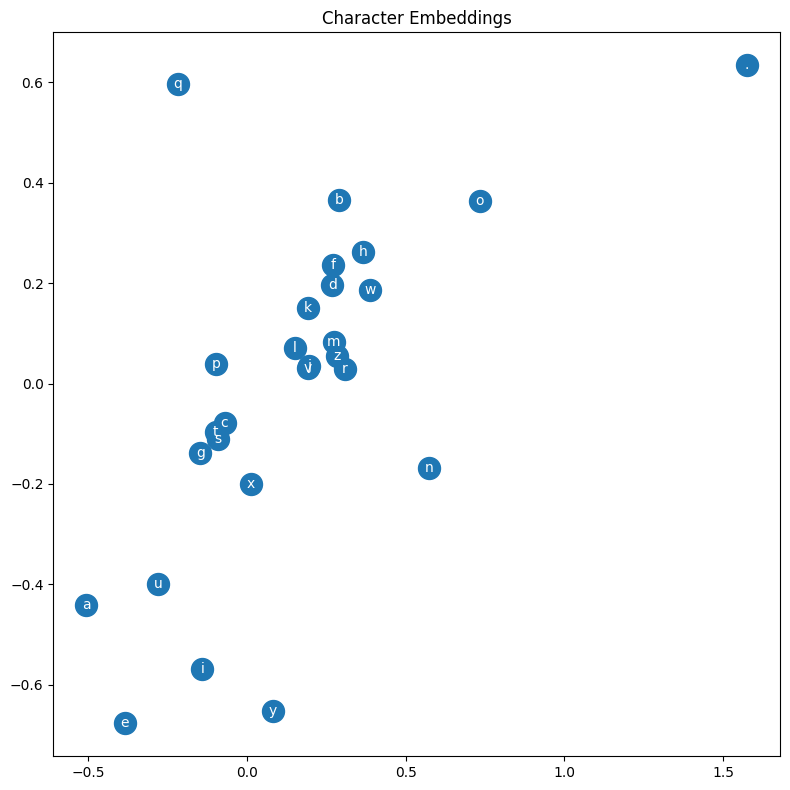

In [47]:
# Visualize The Embeddings
plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=250)
for i in range(C.shape[0]):
    plt.text(
        C[i, 0].item(),
        C[i, 1].item(),
        num_to_text[i],
        ha="center",
        va="center",
        color="white",
    )

plt.title("Character Embeddings")
plt.tight_layout()
# plt.grid("minor")
plt.show()

## Increase The Model Parameters

- The model is not powerful enough. Let's:
  - Increase the number of the dimensions of the embeddings.
  - Increase the number of neurons.
- Note: Increaseing the embeddings dimensions means that you can no longer visualize the embeddings in a 2D space.

In [48]:
X, y = build_dataset(names=names, block_size=3, print_info=False)
data: Dataset = MyDataset(X, y)

X_train, X_dev, X_test, y_train, y_dev, y_test = split_data_into_train_dev_test(
    data=data
)


X.shape=torch.Size([228152, 3]), Y.shape=torch.Size([228152])
X_train.shape=torch.Size([195069, 3]); X_dev.shape=torch.Size([21675, 3]); X_test.shape=torch.Size([11408, 3])


In [49]:
g = torch.Generator().manual_seed(5)

# Parameters
emb_dim: int = 10  # embedding dimension
block_size: int = 3  # size of the context window for each input sequence
M: int = emb_dim * block_size  # number of inputs
n_nodes: int = 300  # number of hidden nodes
learning_rate: float = 0.1  # learning rate
batch_size: int = 32  # batch size
epochs: int = 100_000  # number of epochs
C: Tensor = torch.randn((n_chars, emb_dim), generator=g)
W1: Tensor = torch.randn((M, n_nodes), generator=g)
b1: Tensor = torch.randn(n_nodes, generator=g)
W2: Tensor = torch.randn(n_nodes, n_chars, generator=g)  # (100, 27)
b2: Tensor = torch.randn(n_chars, generator=g)  # (27,)
print(f"{C.shape = }")
parameters: list[Tensor] = [C, W1, b1, W2, b2]
n_parameters: int = sum([p.nelement() for p in parameters])
print(f"{n_parameters = :,}")

C.shape = torch.Size([27, 10])
n_parameters = 17,697


In [50]:
# Require gradients to be true
for p in parameters:
    p.requires_grad = True

In [51]:
# Use The optimal learning rate to train the model
losses_all: list[float] = []

for epoch in range(epochs):

    # Add mini-batches
    idx: Tensor = torch.randint(0, X_train.shape[0], size=(batch_size,))

    # Step 1: Build an embedding lookup table
    # Embed the input
    emb: Tensor = F.one_hot(X_train[idx], num_classes=n_chars).float() @ C

    # Forward pass
    # Step 2: Build The Hidden Layer
    # Reshape the input to match the shape of the weight matrix
    h: Tensor = emb.view(-1, M) @ W1 + b1
    # Apply a non-linearity
    h = torch.tanh(h)

    # Step 3: Output Layer
    logits: Tensor = torch.matmul(h, W2) + b2  # h @ W2 + b2

    # Calculate the loss: Negative log likelihood loss
    loss: Tensor = F.cross_entropy(logits, y_train[idx])

    # Backward pass
    # Reset gradients
    for p in parameters:
        p.grad = None
    loss.backward()

    # learning rate decay
    if epoch > 70_000:
        learning_rate = 0.01
    elif epoch > 80_000:
        learning_rate = 0.001

    # Update the parameters
    for p in parameters:
        p.data -= learning_rate * p.grad

    # Record the loss
    losses_all.append(loss.item())

    if (epoch + 1) % 10_000 == 0:
        print(f"Epoch: {epoch+1}/{epochs} | Loss: {loss.item():.4f}")

Epoch: 10000/100000 | Loss: 3.0592
Epoch: 20000/100000 | Loss: 3.2513
Epoch: 30000/100000 | Loss: 2.3323
Epoch: 40000/100000 | Loss: 2.4789
Epoch: 50000/100000 | Loss: 2.3411
Epoch: 60000/100000 | Loss: 2.2941
Epoch: 70000/100000 | Loss: 2.2216
Epoch: 80000/100000 | Loss: 2.2883
Epoch: 90000/100000 | Loss: 2.2501
Epoch: 100000/100000 | Loss: 2.0128


In [52]:
# Train loss
emb: Tensor = F.one_hot(X_train, num_classes=n_chars).float() @ C
h: Tensor = emb.view(-1, M) @ W1 + b1
h = torch.tanh(h)
logits: Tensor = torch.matmul(h, W2) + b2  # h @ W2 + b2

loss: Tensor = F.cross_entropy(logits, y_train)
loss

tensor(2.1412, grad_fn=<NllLossBackward0>)

In [53]:
# Dev loss
emb: Tensor = F.one_hot(X_dev, num_classes=n_chars).float() @ C
h: Tensor = emb.view(-1, M) @ W1 + b1
h = torch.tanh(h)
logits: Tensor = torch.matmul(h, W2) + b2  # h @ W2 + b2

loss: Tensor = F.cross_entropy(logits, y_dev)
loss

tensor(2.1909, grad_fn=<NllLossBackward0>)

## Sampling From the Model

In [54]:
g = torch.Generator().manual_seed(5)
n_names: int = 10

for _ in range(n_names):

    name: str = ""
    context: list[int] = [0] * block_size
    gen_names: list[str] = []

    while True:
        enc_input: Tensor = F.one_hot(
            torch.tensor(context), num_classes=n_chars
        ).float()
        emb: Tensor = torch.matmul(enc_input, C)  # (block_size, emb_dim)
        # (1, block_size * emb_dim) @ W1 + b1
        h: Tensor = torch.tanh(torch.matmul(emb.view(1, -1), W1) + b1)
        logits: Tensor = torch.matmul(h, W2) + b2
        probs: Tensor = F.softmax(logits, dim=1)
        idx: int = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [idx]
        gen_names.append(idx)

        if idx == 0:
            break

    print("".join(num_to_text.get(x) for x in gen_names))

karyi.
dippon.
esma.
gam.
jaelihan.
blaylynn.
alynnni.
payva.
medan.
ducce.


In [55]:
enc_input.shape, C.shape

(torch.Size([3, 27]), torch.Size([27, 10]))

In [56]:
emb.shape, W1.shape

(torch.Size([3, 10]), torch.Size([30, 300]))